In [1]:
import torch
import torchvision 
import os
from torch.utils import data
from PIL import Image
import torchvision.datasets as dset
import numpy as np

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import matplotlib.pyplot as plt
import math
import pickle
from torchsummary import summary
from math import ceil
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#vital params



dataset_name="caltech101"
 
model_name="EfficientNetb4_sp"
version = "b4"

base_model = [
    # expand_ratio, channels, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

phi_values = {
    # tuple of: (phi_value, resolution, drop_rate)
    "b0": (0, 224, 0.2),  # alpha, beta, gamma, depth = alpha ** phi
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

phi, res, drop_rate = phi_values[version]
#hyperparameters
batch_size=5
num_classes=-1
learning_rate=0.001
input_size=784
image_size=(res,res)


if dataset_name == "tsrd":
    num_classes=58
elif dataset_name == "cifar10":
    num_classes=10
elif dataset_name == "caltech101":
    num_classes=101
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Model: "+model_name +" with {} classes".format(num_classes)+
      " running on: "+dataset_name)


# load data through imagefolder
if dataset_name == "tsrd":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225]),

    ])

    train_dir = "../../dataset/data"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [5000, 998])
    train_set, test_set = data.random_split(train_set,[4000, 1000])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
elif dataset_name == "caltech101":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225]),

    ])

    train_dir = "../../dataset/caltech101"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [7477, 1200])
    train_set, test_set = data.random_split(train_set,[6277, 1200])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
    
    
elif dataset_name == "cifar10":
    
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5, 0.5, 0.5] , std = [0.5, 0.5, 0.5]),

    ])

    bigtrain_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=main_transforms)
    train_set, valid_set = data.random_split(bigtrain_set, [40000, 10000])
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=main_transforms)


    train_dataloader = torch.utils.data.DataLoader(train_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    val_dataloader = torch.utils.data.DataLoader(valid_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    test_dataloader = torch.utils.data.DataLoader(test_set,
                                                  batch_size=batch_size,
                                                  shuffle=False, num_workers=2)




print("Dataset size: Train: {}, Valid: {}, Test: {}"
      .format(len(train_set),len(valid_set),len(test_set)))

print(head_train_set.class_to_idx)
print(train_set[0][0].shape)
print("Datasets loaded and prepared")


Model: EfficientNetb4_sp with 101 classes running on: caltech101
Dataset size: Train: 6277, Valid: 1200, Test: 1200
{'Faces': 0, 'Faces_easy': 1, 'Leopards': 2, 'Motorbikes': 3, 'accordion': 4, 'airplanes': 5, 'anchor': 6, 'ant': 7, 'barrel': 8, 'bass': 9, 'beaver': 10, 'binocular': 11, 'bonsai': 12, 'brain': 13, 'brontosaurus': 14, 'buddha': 15, 'butterfly': 16, 'camera': 17, 'cannon': 18, 'car_side': 19, 'ceiling_fan': 20, 'cellphone': 21, 'chair': 22, 'chandelier': 23, 'cougar_body': 24, 'cougar_face': 25, 'crab': 26, 'crayfish': 27, 'crocodile': 28, 'crocodile_head': 29, 'cup': 30, 'dalmatian': 31, 'dollar_bill': 32, 'dolphin': 33, 'dragonfly': 34, 'electric_guitar': 35, 'elephant': 36, 'emu': 37, 'euphonium': 38, 'ewer': 39, 'ferry': 40, 'flamingo': 41, 'flamingo_head': 42, 'garfield': 43, 'gerenuk': 44, 'gramophone': 45, 'grand_piano': 46, 'hawksbill': 47, 'headphone': 48, 'hedgehog': 49, 'helicopter': 50, 'ibis': 51, 'inline_skate': 52, 'joshua_tree': 53, 'kangaroo': 54, 'ketch'

In [2]:
globparm=0
class CNNBlock(nn.Module):
    def __init__(
            self, in_channels, out_channels, kernel_size, stride, padding, groups=1
    ):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU() # SiLU <-> Swish

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

class InvertedResidualBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            expand_ratio,
            reduction=4, # squeeze excitation
            survival_prob=0.8, # for stochastic depth
    ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels, hidden_dim, kernel_size=3, stride=1, padding=1,
            )

        self.conv = nn.Sequential(
            CNNBlock(
                hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim,
            ),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs

        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)


class EfficientNet(nn.Module):
    def __init__(self, version, num_classes):
        super(EfficientNet, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
        last_channels = ceil(1280 * width_factor)
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10*91*91, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.features = self.create_features(width_factor, depth_factor, last_channels)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes),
        )
        


        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):

        xs = self.localization(x)

        globparm=xs.shape[1]*xs.shape[2]*xs.shape[3]
        xs = xs.view(-1, globparm)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        
        
    def calculate_factors(self, version, alpha=1.2, beta=1.1):
        phi, res, drop_rate = phi_values[version]
        depth_factor = alpha ** phi
        width_factor = beta ** phi
        return width_factor, depth_factor, drop_rate

    def create_features(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [CNNBlock(3, channels, 3, stride=2, padding=1)]
        in_channels = channels

        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_channels = 4*ceil(int(channels*width_factor) / 4)
            layers_repeats = ceil(repeats * depth_factor)

            for layer in range(layers_repeats):
                features.append(
                    InvertedResidualBlock(
                        in_channels,
                        out_channels,
                        expand_ratio=expand_ratio,
                        stride = stride if layer == 0 else 1,
                        kernel_size=kernel_size,
                        padding=kernel_size//2, # if k=1:pad=0, k=3:pad=1, k=5:pad=2
                    )
                )
                in_channels = out_channels

        features.append(
            CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
        )

        return nn.Sequential(*features)

    def forward(self, x):
        self.stn(x)
        x = self.pool(self.features(x))
        
        return self.classifier(x.view(x.shape[0], -1))




model = EfficientNet(
    version=version,
    num_classes=num_classes,
).to(device)

model = model.to(device)

#pretesting model for shape
x=torch.randn(1,3,res,res)
x=x.to(device)
print(x.shape)
print(model(x).shape)

torch.Size([1, 3, 380, 380])
torch.Size([1, 101])


C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


In [5]:
model = EfficientNet(
    version=version,
    num_classes=num_classes,
).to(device)

model = model.to(device)

from thop import profile
import colorama
from colorama import Fore,Style
#vital params
def getGFLOPS(test_model):
    model=test_model.to(device)
    input = torch.randn(1, 3,res, res).to(device)
    macs, params = profile(model, inputs=(input, ))

    print(Fore.BLUE + "The model requires: {:.4f} GFLOPS".format(macs/1000_000_000))
    print(Style.RESET_ALL)
    return macs
getGFLOPS(model)

#pretesting model for shape
x=torch.randn(batch_size,3,res,res)
x=x.to(device)
print(x.shape)
print(model(x).shape)
print(summary(model, input_size=(3, res, res)))
print("model shape ready")

#initailise network


#loss and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)

print("model initialised")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.SiLU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CNNBlock'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Sigmoid'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.SqueezeExcitation'>. Treat it as zero 

C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ..\aten\src\ATen\native\BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


torch.Size([5, 101])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 374, 374]           1,184
         MaxPool2d-2          [-1, 8, 187, 187]               0
              ReLU-3          [-1, 8, 187, 187]               0
            Conv2d-4         [-1, 10, 183, 183]           2,010
         MaxPool2d-5           [-1, 10, 91, 91]               0
              ReLU-6           [-1, 10, 91, 91]               0
            Linear-7                   [-1, 32]       2,649,952
              ReLU-8                   [-1, 32]               0
            Linear-9                    [-1, 6]             198
           Conv2d-10         [-1, 42, 190, 190]           1,134
      BatchNorm2d-11         [-1, 42, 190, 190]              84
             SiLU-12         [-1, 42, 190, 190]               0
         CNNBlock-13         [-1, 42, 190, 190]               0
           Conv2d-

In [4]:
# This is the testing part
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(model)

def test(model, test_loader, istest= False, doprint=True):
    model.eval()
    test_loss = 0
    correct = 0
    TP=0
    TN=0
    FN=0
    FP=0
    test_loss = 0.0
    
    with torch.no_grad(): # disable gradient calculation for efficiency
        for data, target in tqdm(test_loader):
            # Prediction
            data=data.to(device=device)
            target=target.to(device=device)
            optimizer.zero_grad()
            
            output = model(data)
            loss=criterion(output,target)
            
            # Compute loss & accuracy
            test_loss+=loss.item()*data.size(0)

            
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in this batch are correct
            
            #print("pred={} , target={} , judge={}".format(pred.item(),target.item(),pred.eq(target.view_as(pred)).sum().item()))

            
    #test_loss /= len(test_loader.dataset)

        
    # Log testing info
    if istest and doprint:
        
        print('Loss: {}   Accuracy: {}/{} ({:.3f}%)'.format(test_loss,
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
        print("Total parameters: {}".format(get_n_params(model)))
    elif doprint:
        print('Accuracy: {}/{} ({:.3f}%)'.format(
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
    return 100.000 * correct / len(test_loader.dataset)
        

print("test defined")

def testshouldearlystop(acclist,minepoch,epochwindow,accwindow):
    runlen=len(acclist)
    if(runlen<minepoch):
        return False
    elif(acclist[-1]>acclist[-2]):
        return False
    
    watchwindow=acclist[-epochwindow:]
    shouldjump=True
    sum=0
    for i in watchwindow:
        sum+=i
    avg = sum/epochwindow
    for i in watchwindow:
        if abs(i-avg)>(accwindow):
            shouldjump=False
    return shouldjump
print("early stop defined")

test defined
early stop defined


In [5]:
now=datetime.now()
dt_string = now.strftime("%Y%m%d%H%M%S")

tensorboard_string="runs/"+model_name+dt_string
grandstore_string="grandstore/"+dataset_name+"_"+model_name+dt_string+".pkl"
print("tensorboard_string:")
print(tensorboard_string)
print("grandstore_string:")
print(grandstore_string)


writer = SummaryWriter(tensorboard_string)


tensorboard_string:
runs/EfficientNetb4_sp20220104210003
grandstore_string:
grandstore/caltech101_EfficientNetb4_sp20220104210003.pkl


In [6]:
#This is the training part

# Grand_store={
#     'total_epoch_run':-1
#     'topmodels':-1
#     'lastmodel':-1
#     'acclog':[]
#     'maxacc':-1
#     'minacc':101
# }
# train_epoch={
#     "numofepoch":-1
#     "accuracy":-1
#     "model_state":model.state_dict(),
#     "optim_state":optimizer.state_dict(),
#     "totaltrain_loss":totaltrain_loss,
#     "totalvalid_loss":totalvalid_loss
# }

def training(max_epoch=120, top_accuracy_track=3, grandstore={},
             minepoch=30,epochwindow=10,accwindow=0.35):

    grandstore['total_epoch_run']=0
    grandstore['topmodels']=[]
    grandstore['acclog']=[]
    grandstore['maxacc']=-1
    grandstore['minacc']=101
    
    for epoch in range(0,max_epoch):
        
        grandstore['total_epoch_run']=epoch+1
        
        train_epoch={
        "numofepoch":grandstore['total_epoch_run']
        }
    
        train_loss=0.0
        valid_loss=0.0
        print("Running epoch: {}".format(epoch+1))

        model.train()
        totaltrain_loss=0
        
        #this is the training part
        for data,target in tqdm(train_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            totaltrain_loss += train_loss

        #this is the validation part
        model.eval()
        totalvalid_loss=0;
        correct = 0
        for data,target in tqdm(val_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output=model(data)
            loss=criterion(output,target)
            valid_loss=loss.item()*data.size(0)
            #train_loss = train_loss/len(train_dataloader.dataset)
            #valid_loss = valid_loss/len(val_dataloader.dataset)
            totalvalid_loss+=valid_loss
            
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in t
        

        training_accuracy=100. * correct / len(val_dataloader.dataset)
        train_epoch["accuracy"]=training_accuracy
        train_epoch["totaltrain_loss"]=totaltrain_loss
        train_epoch["totalvalid_loss"]=totalvalid_loss
        
        #writings to the GrandStore
        
        grandstore['acclog'].append(training_accuracy)
        
        if training_accuracy < grandstore['minacc']:
            grandstore['minacc'] = training_accuracy
            
        if training_accuracy > grandstore['maxacc']:
            grandstore['maxacc'] = training_accuracy
        

        if epoch < top_accuracy_track:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'].append((training_accuracy,thisepochtestresult,epoch+1,train_epoch))
            #if error print this
            grandstore['topmodels'].sort()

        elif training_accuracy > grandstore['topmodels'][0][0]:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'][0]=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            #if error print this
            grandstore['topmodels'].sort()

        if epoch == (max_epoch-1):
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
                     
        writer.add_scalar('Training Loss',totaltrain_loss,global_step = epoch)
        writer.add_scalar('Valid Loss',totalvalid_loss,global_step = epoch)
        writer.add_scalar('Accuracy',training_accuracy,global_step = epoch)
        
        print('Accuracy: {:.3f}'.format(training_accuracy))
        print('Training Loss: {:.4f} \tValidation Loss: {:.4f}\n'.format(totaltrain_loss, totalvalid_loss))
        
        #early stopping criteria
        if(testshouldearlystop(acclist=grandstore['acclog'],
                               minepoch = minepoch,
                               epochwindow = epochwindow,
                               accwindow = accwindow)):
            print("early stop occured!!")
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            return grandstore
    
    return grandstore
        


In [7]:
TOP_ACCURACY_TRACK = 10
# max_epoch=120, top_accuracy_track=3, grandstore={},
# minepoch=30,epochwindow=10,accwindow=0.35

Grandstore=training(max_epoch=250,
                    minepoch=200,
                    top_accuracy_track=TOP_ACCURACY_TRACK,
                    epochwindow=10,
                    accwindow=0.25                 
                   )

Running epoch: 1


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 7.500
Training Loss: 17144433.0184 	Validation Loss: 5178.4482

Running epoch: 2


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 9.167
Training Loss: 16767016.6088 	Validation Loss: 5132.6632

Running epoch: 3


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 9.417
Training Loss: 16755737.8254 	Validation Loss: 5099.8022

Running epoch: 4


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 9.667
Training Loss: 16745092.2162 	Validation Loss: 5086.8950

Running epoch: 5


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 9.250
Training Loss: 16643835.2626 	Validation Loss: 5096.8457

Running epoch: 6


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 8.250
Training Loss: 16639438.6406 	Validation Loss: 5091.0093

Running epoch: 7


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 9.333
Training Loss: 16586741.9899 	Validation Loss: 5078.5698

Running epoch: 8


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 6.333
Training Loss: 16684741.4833 	Validation Loss: 5087.2026

Running epoch: 9


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 9.083
Training Loss: 16577757.1980 	Validation Loss: 5108.3908

Running epoch: 10


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 9.417
Training Loss: 16573578.5818 	Validation Loss: 5089.7045

Running epoch: 11


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 9.167
Training Loss: 16574235.6273 	Validation Loss: 5095.7591

Running epoch: 12


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 9.500
Training Loss: 16601061.7695 	Validation Loss: 5061.3491

Running epoch: 13


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 8.250
Training Loss: 16541716.3375 	Validation Loss: 5090.1597

Running epoch: 14


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 9.250
Training Loss: 16516626.9122 	Validation Loss: 5035.6295

Running epoch: 15


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 14.167
Training Loss: 16370140.9945 	Validation Loss: 4974.3991

Running epoch: 16


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 14.250
Training Loss: 16249309.5975 	Validation Loss: 4989.1954

Running epoch: 17


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 17.083
Training Loss: 15681011.4719 	Validation Loss: 5445.0932

Running epoch: 18


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 26.000
Training Loss: 14696082.5502 	Validation Loss: 4744.5903

Running epoch: 19


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 24.333
Training Loss: 13950953.2157 	Validation Loss: 8670.6719

Running epoch: 20


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 26.083
Training Loss: 13405462.6840 	Validation Loss: 7946.1844

Running epoch: 21


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 29.083
Training Loss: 13123692.2112 	Validation Loss: 10126.9878

Running epoch: 22


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 33.167
Training Loss: 12547603.3941 	Validation Loss: 3783.5378

Running epoch: 23


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 35.333
Training Loss: 12047517.9589 	Validation Loss: 4139.7219

Running epoch: 24


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 38.000
Training Loss: 11517211.6341 	Validation Loss: 5162.5886

Running epoch: 25


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 39.167
Training Loss: 11045663.1759 	Validation Loss: 3367.4147

Running epoch: 26


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 35.333
Training Loss: 10537216.5693 	Validation Loss: 5639.2021

Running epoch: 27


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 43.417
Training Loss: 10109845.8459 	Validation Loss: 3042.7947

Running epoch: 28


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 45.333
Training Loss: 9679601.4980 	Validation Loss: 2902.4465

Running epoch: 29


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 46.750
Training Loss: 9172947.3784 	Validation Loss: 2902.5458

Running epoch: 30


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 48.917
Training Loss: 9007342.8213 	Validation Loss: 2784.5906

Running epoch: 31


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 48.417
Training Loss: 8434039.1765 	Validation Loss: 2767.2038

Running epoch: 32


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 52.417
Training Loss: 8190706.5753 	Validation Loss: 2600.2112

Running epoch: 33


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 51.167
Training Loss: 7806802.0583 	Validation Loss: 2903.2037

Running epoch: 34


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 54.000
Training Loss: 7497210.6944 	Validation Loss: 2425.7316

Running epoch: 35


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 56.167
Training Loss: 7086830.2537 	Validation Loss: 2367.6156

Running epoch: 36


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 56.333
Training Loss: 6734916.7039 	Validation Loss: 2416.8529

Running epoch: 37


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 56.667
Training Loss: 6285514.6188 	Validation Loss: 2244.1100

Running epoch: 38


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 56.833
Training Loss: 5939735.0945 	Validation Loss: 2614.6585

Running epoch: 39


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 59.500
Training Loss: 5495539.4935 	Validation Loss: 2274.8288

Running epoch: 40


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 60.917
Training Loss: 5213497.0055 	Validation Loss: 2099.8077

Running epoch: 41


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 60.833
Training Loss: 4848870.2590 	Validation Loss: 2149.1928

Running epoch: 42


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 63.167
Training Loss: 4414090.4476 	Validation Loss: 1971.0769

Running epoch: 43


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 63.250
Training Loss: 4056334.3254 	Validation Loss: 2025.1033

Running epoch: 44


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 62.333
Training Loss: 3698305.9308 	Validation Loss: 2078.5614

Running epoch: 45


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 63.333
Training Loss: 3204865.7768 	Validation Loss: 2228.1502

Running epoch: 46


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.333
Training Loss: 2981311.8401 	Validation Loss: 2127.7493

Running epoch: 47


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 61.417
Training Loss: 2574724.4281 	Validation Loss: 2284.3775

Running epoch: 48


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.000
Training Loss: 2441015.2327 	Validation Loss: 2176.1735

Running epoch: 49


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.167
Training Loss: 2173468.8108 	Validation Loss: 2263.5844

Running epoch: 50


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.833
Training Loss: 1880923.9183 	Validation Loss: 2198.6519

Running epoch: 51


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.167
Training Loss: 1764687.3979 	Validation Loss: 2182.7834

Running epoch: 52


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.583
Training Loss: 1550507.5691 	Validation Loss: 2312.2077

Running epoch: 53


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.250
Training Loss: 1406932.1195 	Validation Loss: 2303.8407

Running epoch: 54


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.833
Training Loss: 1220542.9137 	Validation Loss: 2318.4859

Running epoch: 55


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.750
Training Loss: 1246289.9118 	Validation Loss: 2359.2573

Running epoch: 56


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.417
Training Loss: 1071961.4338 	Validation Loss: 2449.3564

Running epoch: 57


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 64.083
Training Loss: 990920.1696 	Validation Loss: 2519.7256

Running epoch: 58


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 64.167
Training Loss: 1046455.0038 	Validation Loss: 2578.4499

Running epoch: 59


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.500
Training Loss: 895572.1872 	Validation Loss: 2572.2737

Running epoch: 60


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.167
Training Loss: 885904.5495 	Validation Loss: 2504.0648

Running epoch: 61


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 63.917
Training Loss: 738544.3489 	Validation Loss: 2535.4899

Running epoch: 62


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.417
Training Loss: 787591.6059 	Validation Loss: 2660.1969

Running epoch: 63


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 63.417
Training Loss: 712186.0710 	Validation Loss: 2619.2516

Running epoch: 64


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 63.750
Training Loss: 651048.0772 	Validation Loss: 2633.8848

Running epoch: 65


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 64.250
Training Loss: 771338.2070 	Validation Loss: 2584.1646

Running epoch: 66


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 64.167
Training Loss: 593093.2058 	Validation Loss: 2614.9355

Running epoch: 67


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 63.583
Training Loss: 626036.3735 	Validation Loss: 2701.0989

Running epoch: 68


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.750
Training Loss: 545109.5870 	Validation Loss: 2701.2476

Running epoch: 69


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.833
Training Loss: 494058.9106 	Validation Loss: 2761.3375

Running epoch: 70


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.333
Training Loss: 624211.8740 	Validation Loss: 2590.0507

Running epoch: 71


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.750
Training Loss: 546532.5761 	Validation Loss: 2781.7682

Running epoch: 72


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.833
Training Loss: 517191.8180 	Validation Loss: 2750.0955

Running epoch: 73


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.750
Training Loss: 476347.2214 	Validation Loss: 2679.5413

Running epoch: 74


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 64.417
Training Loss: 532054.5699 	Validation Loss: 2804.8014

Running epoch: 75


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.667
Training Loss: 470898.1349 	Validation Loss: 2745.2387

Running epoch: 76


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.750
Training Loss: 542814.8164 	Validation Loss: 2737.9321

Running epoch: 77


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.833
Training Loss: 408404.4365 	Validation Loss: 2748.0678

Running epoch: 78


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.000
Training Loss: 410507.3943 	Validation Loss: 2785.1708

Running epoch: 79


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.750
Training Loss: 470968.8239 	Validation Loss: 2867.4792

Running epoch: 80


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 64.417
Training Loss: 453081.5495 	Validation Loss: 2841.3347

Running epoch: 81


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 64.250
Training Loss: 374498.3507 	Validation Loss: 2973.5777

Running epoch: 82


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 65.333
Training Loss: 431415.6267 	Validation Loss: 2822.8353

Running epoch: 83


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 65.083
Training Loss: 475012.1979 	Validation Loss: 2858.2749

Running epoch: 84


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.417
Training Loss: 424261.7721 	Validation Loss: 2828.6962

Running epoch: 85


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.750
Training Loss: 381487.8370 	Validation Loss: 2746.1057

Running epoch: 86


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.250
Training Loss: 354251.2853 	Validation Loss: 2766.5956

Running epoch: 87


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 64.583
Training Loss: 303338.4509 	Validation Loss: 3007.3875

Running epoch: 88


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.083
Training Loss: 332545.5360 	Validation Loss: 2985.3886

Running epoch: 89


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 65.500
Training Loss: 345799.0303 	Validation Loss: 2864.4012

Running epoch: 90


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 64.750
Training Loss: 360356.2823 	Validation Loss: 2904.2164

Running epoch: 91


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.000
Training Loss: 349831.3249 	Validation Loss: 2757.0841

Running epoch: 92


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 65.000
Training Loss: 338294.3569 	Validation Loss: 2805.3286

Running epoch: 93


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 65.583
Training Loss: 327107.8414 	Validation Loss: 2888.5925

Running epoch: 94


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.417
Training Loss: 385814.8356 	Validation Loss: 2856.4502

Running epoch: 95


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.583
Training Loss: 281472.6014 	Validation Loss: 2900.3110

Running epoch: 96


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.417
Training Loss: 315778.1232 	Validation Loss: 2867.3300

Running epoch: 97


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 65.583
Training Loss: 291021.3589 	Validation Loss: 2934.6844

Running epoch: 98


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.750
Training Loss: 352274.5701 	Validation Loss: 2847.7900

Running epoch: 99


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 65.417
Training Loss: 301321.6485 	Validation Loss: 2933.6361

Running epoch: 100


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 65.083
Training Loss: 300359.5828 	Validation Loss: 2972.4189

Running epoch: 101


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 66.167
Training Loss: 241176.7828 	Validation Loss: 2844.7031

Running epoch: 102


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 65.250
Training Loss: 233370.0426 	Validation Loss: 3170.2359

Running epoch: 103


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 66.083
Training Loss: 347917.7247 	Validation Loss: 2861.4043

Running epoch: 104


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 65.667
Training Loss: 281277.8960 	Validation Loss: 3107.8856

Running epoch: 105


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 66.000
Training Loss: 298499.0605 	Validation Loss: 2899.6953

Running epoch: 106


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 63.917
Training Loss: 275046.6132 	Validation Loss: 3345.6438

Running epoch: 107


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 65.917
Training Loss: 245160.3361 	Validation Loss: 3067.2868

Running epoch: 108


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 65.500
Training Loss: 238793.8762 	Validation Loss: 3195.3320

Running epoch: 109


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 65.583
Training Loss: 292428.3851 	Validation Loss: 3063.2984

Running epoch: 110


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 65.167
Training Loss: 169709.5799 	Validation Loss: 3029.6437

Running epoch: 111


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 65.833
Training Loss: 259423.4874 	Validation Loss: 2955.7931

Running epoch: 112


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 64.250
Training Loss: 233564.0578 	Validation Loss: 3125.7861

Running epoch: 113


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.500
Training Loss: 246282.2749 	Validation Loss: 2871.7753

Running epoch: 114


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.417
Training Loss: 270226.9074 	Validation Loss: 3017.6441

Running epoch: 115


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.167
Training Loss: 204345.3643 	Validation Loss: 3048.0586

Running epoch: 116


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.667
Training Loss: 224977.4180 	Validation Loss: 3100.4880

Running epoch: 117


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 66.083
Training Loss: 242936.5249 	Validation Loss: 3116.6640

Running epoch: 118


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 66.333
Training Loss: 223135.6406 	Validation Loss: 3075.3614

Running epoch: 119


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.000
Training Loss: 259496.4984 	Validation Loss: 3140.1770

Running epoch: 120


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 65.917
Training Loss: 261780.1482 	Validation Loss: 2986.9417

Running epoch: 121


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 66.250
Training Loss: 206152.1449 	Validation Loss: 3108.4436

Running epoch: 122


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.583
Training Loss: 192571.1642 	Validation Loss: 3145.0020

Running epoch: 123


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.083
Training Loss: 200037.8141 	Validation Loss: 2945.0977

Running epoch: 124


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.667
Training Loss: 265997.9929 	Validation Loss: 3041.5303

Running epoch: 125


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.167
Training Loss: 170056.6325 	Validation Loss: 2982.2591

Running epoch: 126


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 65.917
Training Loss: 212504.3153 	Validation Loss: 3100.2784

Running epoch: 127


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 66.583
Training Loss: 235442.7584 	Validation Loss: 3089.0187

Running epoch: 128


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 65.417
Training Loss: 226607.5559 	Validation Loss: 3052.8317

Running epoch: 129


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.667
Training Loss: 169345.9414 	Validation Loss: 2949.6019

Running epoch: 130


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.583
Training Loss: 205688.3140 	Validation Loss: 2998.8119

Running epoch: 131


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.833
Training Loss: 187012.6347 	Validation Loss: 3092.1574

Running epoch: 132


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.083
Training Loss: 198661.4123 	Validation Loss: 2968.0721

Running epoch: 133


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 66.833
Training Loss: 127492.2223 	Validation Loss: 3149.4090

Running epoch: 134


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.500
Training Loss: 213248.6746 	Validation Loss: 3148.3984

Running epoch: 135


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.000
Training Loss: 197862.0656 	Validation Loss: 3025.4150

Running epoch: 136


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.000
Training Loss: 187103.0270 	Validation Loss: 3219.6175

Running epoch: 137


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 66.833
Training Loss: 182693.9147 	Validation Loss: 2968.1452

Running epoch: 138


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 66.167
Training Loss: 156193.1461 	Validation Loss: 3127.4140

Running epoch: 139


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 66.000
Training Loss: 186877.2033 	Validation Loss: 3147.4027

Running epoch: 140


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 66.250
Training Loss: 196936.7903 	Validation Loss: 3244.7056

Running epoch: 141


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 66.250
Training Loss: 201331.1158 	Validation Loss: 3207.5229

Running epoch: 142


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.167
Training Loss: 176834.6053 	Validation Loss: 3070.9911

Running epoch: 143


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.667
Training Loss: 176460.2447 	Validation Loss: 3019.0448

Running epoch: 144


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 66.250
Training Loss: 221704.0960 	Validation Loss: 3279.0383

Running epoch: 145


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 66.167
Training Loss: 191446.2325 	Validation Loss: 3280.6273

Running epoch: 146


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 66.833
Training Loss: 162038.7877 	Validation Loss: 3217.2603

Running epoch: 147


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 66.417
Training Loss: 117257.6838 	Validation Loss: 3147.6523

Running epoch: 148


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.500
Training Loss: 187568.3209 	Validation Loss: 3208.7262

Running epoch: 149


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.167
Training Loss: 165769.5657 	Validation Loss: 3224.8166

Running epoch: 150


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.000
Training Loss: 137221.2769 	Validation Loss: 3340.4512

Running epoch: 151


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.083
Training Loss: 191594.9519 	Validation Loss: 3186.6542

Running epoch: 152


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.000
Training Loss: 170305.4513 	Validation Loss: 3217.7739

Running epoch: 153


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.750
Training Loss: 178749.0208 	Validation Loss: 3161.5273

Running epoch: 154


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.500
Training Loss: 136210.9737 	Validation Loss: 3188.5485

Running epoch: 155


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.167
Training Loss: 166052.6543 	Validation Loss: 3160.6721

Running epoch: 156


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.667
Training Loss: 191548.0737 	Validation Loss: 3181.8557

Running epoch: 157


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.500
Training Loss: 142272.9562 	Validation Loss: 3048.4083

Running epoch: 158


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.083
Training Loss: 104099.3013 	Validation Loss: 3121.2901

Running epoch: 159


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.250
Training Loss: 186906.9981 	Validation Loss: 3022.5857

Running epoch: 160


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.583
Training Loss: 150473.1639 	Validation Loss: 3099.0266

Running epoch: 161


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 66.667
Training Loss: 183566.1282 	Validation Loss: 3061.7366

Running epoch: 162


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.500
Training Loss: 129387.2479 	Validation Loss: 3176.8061

Running epoch: 163


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 66.417
Training Loss: 67575.8210 	Validation Loss: 3178.9235

Running epoch: 164


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.417
Training Loss: 254815.3766 	Validation Loss: 3028.8425

Running epoch: 165


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.667
Training Loss: 122735.2764 	Validation Loss: 3167.3518

Running epoch: 166


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.000
Training Loss: 139993.5974 	Validation Loss: 3323.0481

Running epoch: 167


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.000
Training Loss: 153295.7333 	Validation Loss: 3264.3206

Running epoch: 168


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 66.333
Training Loss: 137348.6766 	Validation Loss: 3254.9970

Running epoch: 169


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 66.917
Training Loss: 122051.8456 	Validation Loss: 3308.3160

Running epoch: 170


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.417
Training Loss: 168262.7166 	Validation Loss: 3211.4343

Running epoch: 171


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 66.917
Training Loss: 140836.0533 	Validation Loss: 3299.6761

Running epoch: 172


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.083
Training Loss: 109176.5004 	Validation Loss: 3211.3458

Running epoch: 173


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.750
Training Loss: 131910.5774 	Validation Loss: 3068.3114

Running epoch: 174


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.083
Training Loss: 131860.3797 	Validation Loss: 3178.0505

Running epoch: 175


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.500
Training Loss: 140136.5469 	Validation Loss: 3102.0900

Running epoch: 176


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 66.500
Training Loss: 141700.3522 	Validation Loss: 3162.2594

Running epoch: 177


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 66.917
Training Loss: 122305.6613 	Validation Loss: 3280.1298

Running epoch: 178


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 64.917
Training Loss: 135760.5333 	Validation Loss: 3545.6823

Running epoch: 179


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 66.583
Training Loss: 138200.7402 	Validation Loss: 3193.5341

Running epoch: 180


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 66.167
Training Loss: 148263.8924 	Validation Loss: 3338.5680

Running epoch: 181


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 66.917
Training Loss: 114405.9853 	Validation Loss: 3210.2285

Running epoch: 182


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 66.583
Training Loss: 161599.3828 	Validation Loss: 3390.9240

Running epoch: 183


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 66.667
Training Loss: 128616.2449 	Validation Loss: 3372.9474

Running epoch: 184


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.333
Training Loss: 180946.8250 	Validation Loss: 3119.3184

Running epoch: 185


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.917
Training Loss: 109444.4149 	Validation Loss: 3151.8353

Running epoch: 186


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.000
Training Loss: 132103.9038 	Validation Loss: 3177.9764

Running epoch: 187


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.250
Training Loss: 155518.8469 	Validation Loss: 3041.5757

Running epoch: 188


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.500
Training Loss: 108849.1290 	Validation Loss: 3193.6416

Running epoch: 189


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 66.750
Training Loss: 139933.9372 	Validation Loss: 3104.2677

Running epoch: 190


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.250
Training Loss: 117185.0372 	Validation Loss: 3180.9594

Running epoch: 191


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.333
Training Loss: 111811.9448 	Validation Loss: 3229.1564

Running epoch: 192


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 64.583
Training Loss: 146768.3178 	Validation Loss: 3573.7001

Running epoch: 193


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.917
Training Loss: 122638.7511 	Validation Loss: 3361.8983

Running epoch: 194


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.833
Training Loss: 131767.9791 	Validation Loss: 3237.2515

Running epoch: 195


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 66.500
Training Loss: 62950.8659 	Validation Loss: 3415.3484

Running epoch: 196


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.000
Training Loss: 117590.2991 	Validation Loss: 3284.4081

Running epoch: 197


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.667
Training Loss: 96114.4605 	Validation Loss: 3217.0177

Running epoch: 198


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.750
Training Loss: 141651.0468 	Validation Loss: 3210.7212

Running epoch: 199


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.000
Training Loss: 118341.8668 	Validation Loss: 3200.4350

Running epoch: 200


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.000
Training Loss: 135168.4604 	Validation Loss: 3233.7529

Running epoch: 201


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.167
Training Loss: 163159.3426 	Validation Loss: 3186.9257

Running epoch: 202


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.250
Training Loss: 91807.2489 	Validation Loss: 3315.7373

Running epoch: 203


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.250
Training Loss: 152184.7026 	Validation Loss: 3132.4468

Running epoch: 204


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.333
Training Loss: 109243.6785 	Validation Loss: 3390.1847

Running epoch: 205


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.500
Training Loss: 86670.9162 	Validation Loss: 3319.4742

Running epoch: 206


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 66.417
Training Loss: 139160.7733 	Validation Loss: 3368.6290

Running epoch: 207


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.250
Training Loss: 115564.4887 	Validation Loss: 3330.5913

Running epoch: 208


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.250
Training Loss: 120985.5081 	Validation Loss: 3293.8817

Running epoch: 209


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.583
Training Loss: 108279.5254 	Validation Loss: 3259.5653

Running epoch: 210


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.000
Training Loss: 65765.6946 	Validation Loss: 3538.3557

Running epoch: 211


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.500
Training Loss: 204607.2442 	Validation Loss: 3260.6149

Running epoch: 212


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.833
Training Loss: 94333.2340 	Validation Loss: 3321.6930

Running epoch: 213


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.083
Training Loss: 98102.1866 	Validation Loss: 3282.7436

Running epoch: 214


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.417
Training Loss: 104093.7422 	Validation Loss: 3267.6532

Running epoch: 215


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.417
Training Loss: 87322.9405 	Validation Loss: 3233.0770

Running epoch: 216


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 68.000
Training Loss: 135325.5222 	Validation Loss: 3358.7080

Running epoch: 217


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.833
Training Loss: 116413.4389 	Validation Loss: 3363.3587

Running epoch: 218


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.000
Training Loss: 90281.2041 	Validation Loss: 3381.3164

Running epoch: 219


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.167
Training Loss: 92996.4998 	Validation Loss: 3405.9461

Running epoch: 220


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 68.083
Training Loss: 119889.5169 	Validation Loss: 3513.9367

Running epoch: 221


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.500
Training Loss: 103349.5853 	Validation Loss: 3445.9615

Running epoch: 222


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.583
Training Loss: 106253.2025 	Validation Loss: 3567.2649

Running epoch: 223


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.667
Training Loss: 105505.2265 	Validation Loss: 3324.7180

Running epoch: 224


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.083
Training Loss: 108092.9638 	Validation Loss: 3547.0119

Running epoch: 225


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.167
Training Loss: 99949.3084 	Validation Loss: 3438.7815

Running epoch: 226


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 66.167
Training Loss: 98197.9630 	Validation Loss: 3662.0257

Running epoch: 227


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 66.500
Training Loss: 136585.4610 	Validation Loss: 3634.5670

Running epoch: 228


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 66.833
Training Loss: 167109.1498 	Validation Loss: 3401.5230

Running epoch: 229


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.417
Training Loss: 91038.6440 	Validation Loss: 3277.3826

Running epoch: 230


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.417
Training Loss: 118035.8507 	Validation Loss: 3604.1617

Running epoch: 231


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.833
Training Loss: 112142.8866 	Validation Loss: 3455.7843

Running epoch: 232


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.500
Training Loss: 71032.3244 	Validation Loss: 3437.2135

Running epoch: 233


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.833
Training Loss: 122107.8108 	Validation Loss: 3368.8322

Running epoch: 234


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.000
Training Loss: 78061.4231 	Validation Loss: 3541.2983

Running epoch: 235


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.250
Training Loss: 89681.5947 	Validation Loss: 3520.3519

Running epoch: 236


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 68.250
Training Loss: 124494.1990 	Validation Loss: 3406.6539

Running epoch: 237


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.917
Training Loss: 73019.1330 	Validation Loss: 3436.3675

Running epoch: 238


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.167
Training Loss: 98881.8239 	Validation Loss: 3488.8969

Running epoch: 239


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 66.917
Training Loss: 86357.0527 	Validation Loss: 3526.6708

Running epoch: 240


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.667
Training Loss: 100256.6065 	Validation Loss: 3663.0326

Running epoch: 241


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.333
Training Loss: 104319.5869 	Validation Loss: 3615.9972

Running epoch: 242


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.917
Training Loss: 121777.8571 	Validation Loss: 3350.8293

Running epoch: 243


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.417
Training Loss: 90512.0869 	Validation Loss: 3754.2551

Running epoch: 244


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.333
Training Loss: 95420.0679 	Validation Loss: 3620.6560

Running epoch: 245


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.500
Training Loss: 94084.1359 	Validation Loss: 3246.8080

Running epoch: 246


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.750
Training Loss: 84688.7483 	Validation Loss: 3470.9213

Running epoch: 247


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 67.250
Training Loss: 115626.9084 	Validation Loss: 3479.8345

Running epoch: 248


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.833
Training Loss: 102090.8742 	Validation Loss: 3400.7363

Running epoch: 249


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 68.250
Training Loss: 60479.2321 	Validation Loss: 3441.9767

Running epoch: 250


  0%|          | 0/1256 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.583
Training Loss: 110455.0570 	Validation Loss: 3515.8282



Total Run 250 epoch(s)
Accuracy MIN: 6.333333333333333 / MAX: 69.41666666666667

Top 10 performing epochs:
#1 epoch 215	||train_acc 69.42%	||test 71.83%
#2 epoch 225	||train_acc 69.17%	||test 69.17%
#3 epoch 213	||train_acc 69.08%	||test 69.83%
#4 epoch 218	||train_acc 69.00%	||test 70.17%
#5 epoch 248	||train_acc 68.83%	||test 70.83%
#6 epoch 173	||train_acc 68.75%	||test 69.92%
#7 epoch 209	||train_acc 68.58%	||test 71.25%
#8 epoch 245	||train_acc 68.50%	||test 71.67%
#9 epoch 232	||train_acc 68.50%	||test 69.17%
#10 epoch 229	||train_acc 68.42%	||test 68.58%

Last epoch:
epoch 250	||train_acc 67.58%	||test 68.83%

The model has parameters: 59266606


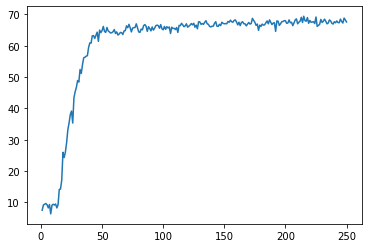

In [8]:
print("Total Run {} epoch(s)".format(Grandstore['total_epoch_run']))

plt.plot(*[range(1,Grandstore['total_epoch_run']+1)],Grandstore['acclog'])
print("Accuracy MIN: {} / MAX: {}".format(Grandstore['minacc'],Grandstore['maxacc']))
print()
print("Top {} performing epochs:".format(TOP_ACCURACY_TRACK))


gstm=Grandstore['topmodels']
for i in range(TOP_ACCURACY_TRACK):
    easy=gstm[TOP_ACCURACY_TRACK-i-1]
    print("#{} epoch {}\t||train_acc {:.2f}%\t||test {:.2f}%".format(i+1,easy[2],easy[0],easy[1]))
print()
print("Last epoch:")
lsmd=Grandstore['lastmodel']
print("epoch {}\t||train_acc {:.2f}%\t||test {:.2f}%".format(Grandstore['total_epoch_run'],lsmd[0],lsmd[1]))
      
print()
print("The model has parameters: {}".format(get_n_params(model)))
#grandstore['lastmodel']=((training_accuracy,train_epoch,thisepochtestresult))
# grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)

In [9]:
  
f1=open(grandstore_string,"wb")
pickle.dump(Grandstore,f1)
f1.close()

print("writings done!")
print("Files at: "+grandstore_string)

# with open(grandstore_string, 'rb') as file:
#     myvar = pickle.load(file)
#     print(myvar)

writings done!
Files at: grandstore/caltech101_EfficientNetb4_sp20220104210003.pkl
